## Understanding Data

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv("../input/mall-customers-kmeans-pcacsv/Mall_Customers_Kmeans_PCA.csv")

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
## For convinence rename the attributes Annual INcome(k$) and Spending Score (1-100)

df.rename({'Annual Income (k$)':'Income',  \
          'Spending Score (1-100)':'Spend_Score'}, axis=1,inplace=True)

In [6]:
df.head()

,CustomerID,Gender,Age,Income,Spend_Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
## To get a high-level understanding on the numerical fields and print out the descriptive summary, lets use describe method()

df.describe()

,CustomerID,Age,Income,Spend_Score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## Traditional Segmentation

<AxesSubplot:xlabel='Income', ylabel='Count'>

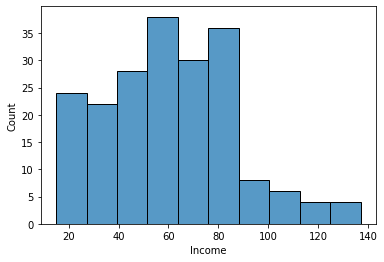

In [8]:
sns.histplot(data=df, x="Income")

Beyond 90k, the frequency in the bins falls sharply and it seems that these 
customers can naturally be considered a separate group representing high-income customers. A good proportion of customers seems to lie in the 50k-90k 
range. These can be considered moderate-income customers. Customers 
earning less than 40k would be low-income customers. 

In [9]:
## Creating three clusters based on the above understanding

df['Cluster']=np.where(df.Income >= 90, 'High_Earners',
                      np.where(df.Income < 50, 'Low_Income', 'Moderate_Income'))

In [10]:
df.groupby('Cluster')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
High_Earners,22.0,108.181818,13.661334,93.0,98.25,103.0,118.25,137.0
Low_Income,72.0,33.027778,11.091136,15.0,22.50,33.5,43.00,49.0
Moderate_Income,106.0,69.377358,10.651584,50.0,61.00,70.0,78.00,88.0


#### Standardising the numerical attributes

In [11]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [12]:
columns_to_scale = ['Age','Income','Spend_Score']
data_scaled=df.copy()

In [13]:
data_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [14]:
data_scaled[columns_to_scale].describe()

,Age,Income,Spend_Score
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-9.603429e-17,-6.128431e-16,-1.121325e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


## Euclidean Distance or Euclidean Measure

In [15]:
sel_cols=['Income','Spend_Score']
cust3=data_scaled[sel_cols].head(3)
cust3

,Income,Spend_Score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913


In [16]:
from scipy.spatial.distance import cdist


In [17]:
cdist(cust3, cust3, metric='euclidean')

array([[0.        , 1.63050555, 1.28167999],
       [1.63050555, 0.        , 2.91186723],
       [1.28167999, 2.91186723, 0.        ]])

In [18]:
# verify the Eucliean distance between Income and Spend_Score

np.sqrt((-1.739+1.739)**2 + (-0.4348-1.1957)**2)

1.6305

## K-means Clustering Algorithm

K-means clustering is a very common unsupervised learning technique with a wide 
range of applications. It is powerful because it is conceptually relatively simple, scales 
to very large datasets, and tends to work well in practice. 

In this section, you will learn 
1) the conceptual foundations of k-means clustering,

2) how to apply k-means clustering to data

3) how to deal with high-dimensional data (that is, data with many different variables) in the context of clustering

K-means clustering is an algorithm that tries to find the best way of grouping data 
points into k different groups, where k is a parameter given to the algorithm. For 
now, we will choose k arbitrarily. We will revisit how to choose k in practice in the next 
chapter. The algorithm then works iteratively to try to find the best grouping. There 
are two steps to this algorithm:
1. The algorithm begins by randomly selecting k points in space to be the centroids of the clusters. Each data point is then assigned to the centroid that is closest to it.
2. The centroids are updated to be the mean of all of the data points assigned to them. The data points are then reassigned to the centroid closest to them.

Step 2 is repeated until none of the data points change the centroid they are assigned 
to after the centroid is updated.

One point to note here is that this algorithm is not deterministic, that is, the outcome 
of the algorithm depends on the starting locations of the centroids. Therefore, it is 
not always guaranteed to find the best grouping. However, in practice, it tends to find 
good groupings while still being computationally inexpensive even for large datasets. 
K-means clustering is fast and easily scalable and is, therefore, the most common 
clustering algorithm used.

In [19]:
cluster_cols=['Income','Spend_Score']
cust4=data_scaled[cluster_cols].head(3)
cust4

,Income,Spend_Score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913


From the plot, there are 5 natural clusters in the data. This tells us that we need to specify 5 as the number of clusters for the k-means algorithm


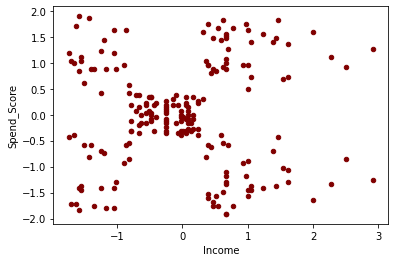

In [20]:
data_scaled.plot.scatter(x='Income', y='Spend_Score', \
                         color='maroon')

print("From the plot, there are 5 natural clusters in the data. This tells us that we need to specify 5 as the number of clusters for the k-means algorithm")

In [21]:
from sklearn.cluster import KMeans
model=KMeans(n_clusters=5, random_state=42)

print("The model instance is created. Note that no clustering has been performed on the data yet. n_clusters specifies the number of clusters to create as 5. Specifying a random state ensures that we get the same results on repeated executions since the k-means algorithm is not deterministic. 42 is an arbitrary choice")

The model instance is created. Note that no clustering has been performed on the data yet. n_clusters specifies the number of clusters to create as 5. Specifying a random state ensures that we get the same results on repeated executions since the k-means algorithm is not deterministic. 42 is an arbitrary choice


In [22]:
model.fit(data_scaled[cluster_cols])
data_scaled['Clusters']=model.predict(data_scaled[cluster_cols])
print("fit the model on the data using the columns in cluster_cols for the purpose. Using the predict method of the k-means model, assign the cluster for each customer to the 'Cluster' variable. Print the first three records of the data_scaled dataset")

fit the model on the data using the columns in cluster_cols for the purpose. Using the predict method of the k-means model, assign the cluster for each customer to the 'Cluster' variable. Print the first three records of the data_scaled dataset


In [23]:
data_scaled.head(3)

,CustomerID,Gender,Age,Income,Spend_Score,Cluster,Clusters
0,1,Male,-1.424569,-1.738999,-0.434801,Low_Income,3
1,2,Male,-1.281035,-1.738999,1.195704,Low_Income,0
2,3,Female,-1.352802,-1.700830,-1.715913,Low_Income,3


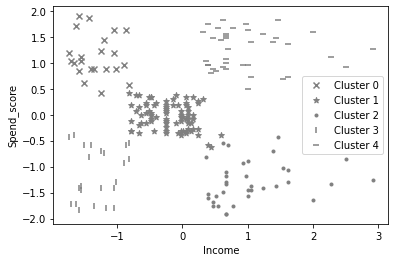

In [24]:
markers = ['x', '*', '.','|','_']

for clust in range(5):
    temp = data_scaled[data_scaled.Clusters == clust]
    plt.scatter(temp.Income, temp.Spend_Score, \
                marker=markers[clust], \
                color = 'gray',\
                label="Cluster "+str(clust))
plt.xlabel('Income')
plt.ylabel('Spend_score')
plt.legend()
plt.show()

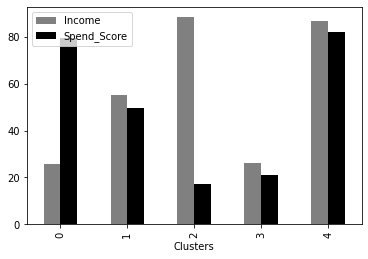

In [25]:
df['Clusters']=data_scaled.Clusters
df.groupby('Clusters')[['Income','Spend_Score']].mean().plot.bar(color=['gray','black'])
plt.show()

Each cluster can be described as follows:

• Cluster 0: Low-income high spenders

• Cluster 1: Moderate-income moderate spenders

• Cluster 2: High-income low spenders

• Cluster 3: Low-income low spenders

• Cluster 4: High-income high spender


## Dimensionality Reduction

In the previous mall segementation, we had used Income and Spend Scores attributes for the segementation, what if we add Age, to the segmentation.
So far, we performed the Euclidean distance for the two dimensional attributes and Euclidean distance is very well handled for the multi dimensions, once the distance is defined, the usual machine learning algorithms for clustering, say K-means, can be employed.

Motivation for Dimensional Reduction:
    
 Since, we have introduced Age as the third dimension, however we need to first reduce the data to two dimensions.


Dimensionality reduction techniques are commonly employed for this. The idea of dimensionality reduction is that multi-dimensional data is reduced, usually to 
two dimensions, for visualization purposes, in a manner that preserves the distance between the points. A simple and intuitive way to understand dimensionality 
reduction is to consider that pictures and videos we watch on two-dimensional screens are in fact representations of a three-dimensional world, reduced to two 
dimensions so that they can be visualized on the two-dimensional screen. While we do lose a dimension (depth) in the images, the loss is minimal and does not 
ruin the viewing experience. Dimensionality reduction, when applied to our multidimensional dataset, would condense most of the information into two dimensions to enable visualization




## Principal Component Analysis

The techniques for dimensionality reduction are many. Will look and apply the most popular approach by far – Principal Component Analysis (PCA). PCA is a method of transforming data. It takes the original features/dimensions and creates 
new features/dimensions that capture the most variance in the data. In other words, it creates dimensions that contain the most amount of information about the data, so that when you take the first two Principal Components (PCs), that is, dimensions, 
you are left with most of the information about the data, but reduced to only two dimensions.




 using the PCA module from the scikit-learn package. Usage of the package is similar to the usage of the KMeans module. 
 Similar to the KMeans module, the PCA module has fit and transform methods. 
 Fitting would mean calculating the PCs (Principal Components) from the data and transforming would mean 
 representing the data in these new PCs. The fit_transform method combines the two methods.
 n_components=N, where "N" is the number of PCs to calculate, cols is a list of columns to calculate the PCAs from
 and data is the dataset containing these columns. pca_res would contain the transformed data.


from sklearn import decomposition

pca = decomposition.PCA(n_components=N)

pca_res = pca.fit_transform(data[cols])

To summarize the discussion on PCA, when performing clustering with high-dimensional data, the cluster formation approach remains the same. It is just the 
visualization that now needs an additional step – reduction to two dimensions using 
a dimensionality reduction technique such as PCA. In the exercise that follows, 
you will try this firsthand by clustering the mall customers using age, income, and 
spend score.



In [26]:
cluster_cols = ['Age','Income','Spend_Score'] 
data_scaled[cluster_cols].head(3)  ## Remember we already scaled these attributes

,Age,Income,Spend_Score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913


In [27]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(data_scaled[cluster_cols])

data_scaled['Clusters_4'] = model.predict(data_scaled[cluster_cols])

In [28]:
data_scaled

,CustomerID,Gender,Age,Income,Spend_Score,Cluster,Clusters,Clusters_4
0,1,Male,-1.424569,-1.738999,-0.434801,Low_Income,3,1
1,2,Male,-1.281035,-1.738999,1.195704,Low_Income,0,1
2,3,Female,-1.352802,-1.700830,-1.715913,Low_Income,3,1
3,4,Female,-1.137502,-1.700830,1.040418,Low_Income,0,1
4,5,Female,-0.563369,-1.662660,-0.395980,Low_Income,3,1
...,...,...,...,...,...,...,...,...
195,196,Female,-0.276302,2.268791,1.118061,High_Earners,4,2
196,197,Female,0.441365,2.497807,-0.861839,High_Earners,2,0
197,198,Male,-0.491602,2.497807,0.923953,High_Earners,4,2
198,199,Male,-0.491602,2.917671,-1.250054,High_Earners,2,0


In [29]:
from sklearn import decomposition

pca=decomposition.PCA(n_components=2)

pca_res=pca.fit_transform(data_scaled[cluster_cols])

data_scaled['pc1'] = pca_res[:,0]
data_scaled['pc2'] = pca_res[:,1]


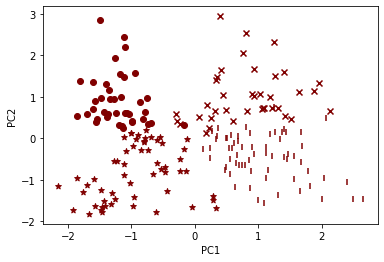

In [30]:
markers = ['x', '*', 'o','|']

for clust in range(4):
    temp = data_scaled[data_scaled.Clusters_4 == clust]
    plt.scatter(temp.pc1, temp.pc2, marker=markers[clust], \
                label="Cluster "+str(clust), \
                color='maroon')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [31]:
data_scaled

,CustomerID,Gender,Age,Income,Spend_Score,Cluster,Clusters,Clusters_4,pc1,pc2
0,1,Male,-1.424569,-1.738999,-0.434801,Low_Income,3,1,-0.615720,-1.763481
1,2,Male,-1.281035,-1.738999,1.195704,Low_Income,0,1,-1.665793,-1.820747
2,3,Female,-1.352802,-1.700830,-1.715913,Low_Income,3,1,0.337862,-1.674799
3,4,Female,-1.137502,-1.700830,1.040418,Low_Income,0,1,-1.456573,-1.772430
4,5,Female,-0.563369,-1.662660,-0.395980,Low_Income,3,1,-0.038465,-1.662740
...,...,...,...,...,...,...,...,...,...,...
195,196,Female,-0.276302,2.268791,1.118061,High_Earners,4,2,-1.093705,2.215577
196,197,Female,0.441365,2.497807,-0.861839,High_Earners,2,0,0.800448,2.540748
197,198,Male,-0.491602,2.497807,0.923953,High_Earners,4,2,-1.119709,2.445169
198,199,Male,-0.491602,2.917671,-1.250054,High_Earners,2,0,0.395411,2.946665


In [32]:
df['Clusters_4']=data_scaled.Clusters_4
df.groupby('Clusters_4')[['Age','Income','Spend_Score']].mean()

,Age,Income,Spend_Score
Clusters_4,,,
0,39.368421,86.500000,19.578947
1,25.438596,40.000000,60.298246
2,32.875000,86.100000,81.525000
3,53.984615,47.707692,39.969231


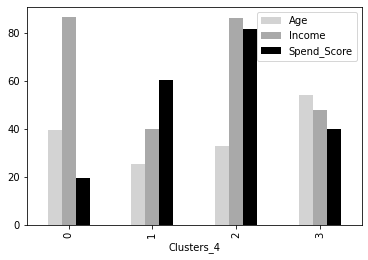

In [33]:
df.groupby('Clusters_4')[['Age','Income','Spend_Score']].mean().plot.bar(color=['lightgray','darkgray','black'])
plt.show()

One way to describe the clusters is as follows: 

Cluster 0: Middle-aged penny pinchers (high income, low spend)

Cluster 1: Young high rollers (younger age, high income, high spend)

Cluster 2: Young aspirers (low income, high spend)

Cluster 3: Old average Joes (average income, average spend